# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 875us/sample - loss: 241.3307 - y1_output_loss: 117.6384 - y2_output_loss: 121.4651 - y1_output_root_mean_squared_error: 10.8962 - y2_output_root_mean_squared_error: 11.0726 - val_loss: 43.4782 - val_y1_output_loss: 20.8240 - val_y2_output_loss: 27.2256 - val_y1_output_root_mean_squared_error: 4.4402 - val_y2_output_root_mean_squared_error: 4.8747
Epoch 2/500
614/614 [==============================] - 0s 138us/sample - loss: 31.1327 - y1_output_loss: 12.5957 - y2_output_loss: 18.4872 - y1_output_root_mean_squared_error: 3.5445 - y2_output_root_mean_squared_error: 4.3092 - val_loss: 36.2951 - val_y1_output_loss: 17.6058 - val_y2_output_loss: 20.8324 - val_y1_output_root_mean_squared_error: 4.1453 - val_y2_output_root_mean_squared_error: 4.3717
Epoch 3/500
614/614 [==============================] - 0s 133us/sample - loss: 22.5631 - y1_output_loss: 9.2944 - y2_output_loss: 13.1157 - y1_

614/614 [==============================] - 0s 131us/sample - loss: 16.5348 - y1_output_loss: 6.0246 - y2_output_loss: 10.4497 - y1_output_root_mean_squared_error: 2.4565 - y2_output_root_mean_squared_error: 3.2405 - val_loss: 30.5463 - val_y1_output_loss: 12.6315 - val_y2_output_loss: 20.5704 - val_y1_output_root_mean_squared_error: 3.4854 - val_y2_output_root_mean_squared_error: 4.2893
Epoch 22/500
614/614 [==============================] - 0s 129us/sample - loss: 13.8103 - y1_output_loss: 5.3529 - y2_output_loss: 8.7359 - y1_output_root_mean_squared_error: 2.2955 - y2_output_root_mean_squared_error: 2.9225 - val_loss: 38.8654 - val_y1_output_loss: 11.7175 - val_y2_output_loss: 30.0417 - val_y1_output_root_mean_squared_error: 3.3701 - val_y2_output_root_mean_squared_error: 5.2448
Epoch 23/500
614/614 [==============================] - 0s 127us/sample - loss: 13.2357 - y1_output_loss: 5.0675 - y2_output_loss: 8.5068 - y1_output_root_mean_squared_error: 2.2408 - y2_output_root_mean_squa

614/614 [==============================] - 0s 127us/sample - loss: 6.9639 - y1_output_loss: 2.4935 - y2_output_loss: 4.4489 - y1_output_root_mean_squared_error: 1.5846 - y2_output_root_mean_squared_error: 2.1102 - val_loss: 9.7319 - val_y1_output_loss: 3.3759 - val_y2_output_loss: 6.2301 - val_y1_output_root_mean_squared_error: 1.8637 - val_y2_output_root_mean_squared_error: 2.5017
Epoch 42/500
614/614 [==============================] - 0s 135us/sample - loss: 7.2933 - y1_output_loss: 2.3379 - y2_output_loss: 4.8890 - y1_output_root_mean_squared_error: 1.5359 - y2_output_root_mean_squared_error: 2.2214 - val_loss: 8.4502 - val_y1_output_loss: 2.7143 - val_y2_output_loss: 5.8540 - val_y1_output_root_mean_squared_error: 1.6652 - val_y2_output_root_mean_squared_error: 2.3827
Epoch 43/500
614/614 [==============================] - 0s 130us/sample - loss: 8.3086 - y1_output_loss: 2.7672 - y2_output_loss: 5.6315 - y1_output_root_mean_squared_error: 1.6471 - y2_output_root_mean_squared_error:

Epoch 62/500
614/614 [==============================] - 0s 128us/sample - loss: 6.1626 - y1_output_loss: 1.7038 - y2_output_loss: 4.4599 - y1_output_root_mean_squared_error: 1.3112 - y2_output_root_mean_squared_error: 2.1079 - val_loss: 15.4434 - val_y1_output_loss: 2.2575 - val_y2_output_loss: 12.6728 - val_y1_output_root_mean_squared_error: 1.5250 - val_y2_output_root_mean_squared_error: 3.6218
Epoch 63/500
614/614 [==============================] - 0s 128us/sample - loss: 4.7312 - y1_output_loss: 1.3659 - y2_output_loss: 3.3230 - y1_output_root_mean_squared_error: 1.1736 - y2_output_root_mean_squared_error: 1.8313 - val_loss: 5.3753 - val_y1_output_loss: 1.3035 - val_y2_output_loss: 4.2499 - val_y1_output_root_mean_squared_error: 1.1539 - val_y2_output_root_mean_squared_error: 2.0109
Epoch 64/500
614/614 [==============================] - 0s 128us/sample - loss: 4.6441 - y1_output_loss: 1.3819 - y2_output_loss: 3.2778 - y1_output_root_mean_squared_error: 1.1779 - y2_output_root_mean

Epoch 83/500
614/614 [==============================] - 0s 129us/sample - loss: 2.9192 - y1_output_loss: 0.6692 - y2_output_loss: 2.2505 - y1_output_root_mean_squared_error: 0.8177 - y2_output_root_mean_squared_error: 1.5002 - val_loss: 5.7528 - val_y1_output_loss: 1.4483 - val_y2_output_loss: 4.6843 - val_y1_output_root_mean_squared_error: 1.2081 - val_y2_output_root_mean_squared_error: 2.0720
Epoch 84/500
614/614 [==============================] - 0s 131us/sample - loss: 3.6376 - y1_output_loss: 0.9498 - y2_output_loss: 2.6839 - y1_output_root_mean_squared_error: 0.9785 - y2_output_root_mean_squared_error: 1.6371 - val_loss: 5.3752 - val_y1_output_loss: 1.0435 - val_y2_output_loss: 4.7464 - val_y1_output_root_mean_squared_error: 1.0284 - val_y2_output_root_mean_squared_error: 2.0779
Epoch 85/500
614/614 [==============================] - 0s 128us/sample - loss: 3.7639 - y1_output_loss: 0.9015 - y2_output_loss: 2.8304 - y1_output_root_mean_squared_error: 0.9532 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 130us/sample - loss: 2.3839 - y1_output_loss: 0.5971 - y2_output_loss: 1.7707 - y1_output_root_mean_squared_error: 0.7756 - y2_output_root_mean_squared_error: 1.3350 - val_loss: 3.1370 - val_y1_output_loss: 0.5077 - val_y2_output_loss: 2.6681 - val_y1_output_root_mean_squared_error: 0.7157 - val_y2_output_root_mean_squared_error: 1.6201
Epoch 105/500
614/614 [==============================] - 0s 127us/sample - loss: 2.2146 - y1_output_loss: 0.5241 - y2_output_loss: 1.6838 - y1_output_root_mean_squared_error: 0.7265 - y2_output_root_mean_squared_error: 1.2987 - val_loss: 6.2453 - val_y1_output_loss: 1.0942 - val_y2_output_loss: 5.4450 - val_y1_output_root_mean_squared_error: 1.0524 - val_y2_output_root_mean_squared_error: 2.2667
Epoch 106/500
614/614 [==============================] - 0s 130us/sample - loss: 1.9600 - y1_output_loss: 0.4336 - y2_output_loss: 1.5112 - y1_output_root_mean_squared_error: 0.6592 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 2.0593 - y1_output_loss: 0.4901 - y2_output_loss: 1.5712 - y1_output_root_mean_squared_error: 0.7001 - y2_output_root_mean_squared_error: 1.2527 - val_loss: 5.1319 - val_y1_output_loss: 0.4198 - val_y2_output_loss: 5.0321 - val_y1_output_root_mean_squared_error: 0.6520 - val_y2_output_root_mean_squared_error: 2.1695
Epoch 125/500
614/614 [==============================] - 0s 130us/sample - loss: 1.8743 - y1_output_loss: 0.3976 - y2_output_loss: 1.5195 - y1_output_root_mean_squared_error: 0.6290 - y2_output_root_mean_squared_error: 1.2160 - val_loss: 6.8801 - val_y1_output_loss: 0.7631 - val_y2_output_loss: 6.2596 - val_y1_output_root_mean_squared_error: 0.8818 - val_y2_output_root_mean_squared_error: 2.4703
Epoch 126/500
614/614 [==============================] - 0s 135us/sample - loss: 1.9841 - y1_output_loss: 0.4556 - y2_output_loss: 1.5176 - y1_output_root_mean_squared_error: 0.6779 - y2_output_root_mean_squared_erro

Epoch 145/500
614/614 [==============================] - 0s 127us/sample - loss: 2.2450 - y1_output_loss: 0.7440 - y2_output_loss: 1.4869 - y1_output_root_mean_squared_error: 0.8647 - y2_output_root_mean_squared_error: 1.2236 - val_loss: 3.2600 - val_y1_output_loss: 0.5533 - val_y2_output_loss: 2.7991 - val_y1_output_root_mean_squared_error: 0.7468 - val_y2_output_root_mean_squared_error: 1.6439
Epoch 146/500
614/614 [==============================] - 0s 126us/sample - loss: 1.9501 - y1_output_loss: 0.4375 - y2_output_loss: 1.5409 - y1_output_root_mean_squared_error: 0.6504 - y2_output_root_mean_squared_error: 1.2357 - val_loss: 3.8675 - val_y1_output_loss: 1.2833 - val_y2_output_loss: 2.5111 - val_y1_output_root_mean_squared_error: 1.1378 - val_y2_output_root_mean_squared_error: 1.6040
Epoch 147/500
614/614 [==============================] - 0s 126us/sample - loss: 1.4700 - y1_output_loss: 0.3260 - y2_output_loss: 1.1412 - y1_output_root_mean_squared_error: 0.5704 - y2_output_root_mea

614/614 [==============================] - 0s 125us/sample - loss: 1.7941 - y1_output_loss: 0.4592 - y2_output_loss: 1.3213 - y1_output_root_mean_squared_error: 0.6799 - y2_output_root_mean_squared_error: 1.1540 - val_loss: 2.2139 - val_y1_output_loss: 0.3652 - val_y2_output_loss: 1.9273 - val_y1_output_root_mean_squared_error: 0.6038 - val_y2_output_root_mean_squared_error: 1.3599
Epoch 166/500
614/614 [==============================] - 0s 126us/sample - loss: 2.0886 - y1_output_loss: 0.5289 - y2_output_loss: 1.5489 - y1_output_root_mean_squared_error: 0.7302 - y2_output_root_mean_squared_error: 1.2472 - val_loss: 3.1685 - val_y1_output_loss: 0.2761 - val_y2_output_loss: 2.9407 - val_y1_output_root_mean_squared_error: 0.5269 - val_y2_output_root_mean_squared_error: 1.7003
Epoch 167/500
614/614 [==============================] - 0s 127us/sample - loss: 1.1166 - y1_output_loss: 0.2318 - y2_output_loss: 0.8777 - y1_output_root_mean_squared_error: 0.4829 - y2_output_root_mean_squared_erro

Epoch 186/500
614/614 [==============================] - 0s 125us/sample - loss: 1.3935 - y1_output_loss: 0.3053 - y2_output_loss: 1.0809 - y1_output_root_mean_squared_error: 0.5527 - y2_output_root_mean_squared_error: 1.0431 - val_loss: 2.4171 - val_y1_output_loss: 0.5004 - val_y2_output_loss: 1.9311 - val_y1_output_root_mean_squared_error: 0.6972 - val_y2_output_root_mean_squared_error: 1.3896
Epoch 187/500
614/614 [==============================] - 0s 125us/sample - loss: 1.4843 - y1_output_loss: 0.3405 - y2_output_loss: 1.1305 - y1_output_root_mean_squared_error: 0.5859 - y2_output_root_mean_squared_error: 1.0682 - val_loss: 3.0397 - val_y1_output_loss: 0.4659 - val_y2_output_loss: 2.7882 - val_y1_output_root_mean_squared_error: 0.6693 - val_y2_output_root_mean_squared_error: 1.6099
Epoch 188/500
614/614 [==============================] - 0s 124us/sample - loss: 3.0505 - y1_output_loss: 0.7680 - y2_output_loss: 2.2693 - y1_output_root_mean_squared_error: 0.8799 - y2_output_root_mea

614/614 [==============================] - 0s 128us/sample - loss: 1.0670 - y1_output_loss: 0.2423 - y2_output_loss: 0.8240 - y1_output_root_mean_squared_error: 0.4871 - y2_output_root_mean_squared_error: 0.9109 - val_loss: 2.1215 - val_y1_output_loss: 0.2842 - val_y2_output_loss: 1.8554 - val_y1_output_root_mean_squared_error: 0.5281 - val_y2_output_root_mean_squared_error: 1.3574
Epoch 207/500
614/614 [==============================] - 0s 127us/sample - loss: 1.2676 - y1_output_loss: 0.2725 - y2_output_loss: 1.0068 - y1_output_root_mean_squared_error: 0.5179 - y2_output_root_mean_squared_error: 0.9997 - val_loss: 3.9061 - val_y1_output_loss: 0.4889 - val_y2_output_loss: 3.7116 - val_y1_output_root_mean_squared_error: 0.6813 - val_y2_output_root_mean_squared_error: 1.8553
Epoch 208/500
614/614 [==============================] - 0s 129us/sample - loss: 1.5595 - y1_output_loss: 0.4086 - y2_output_loss: 1.1703 - y1_output_root_mean_squared_error: 0.6401 - y2_output_root_mean_squared_erro

Epoch 227/500
614/614 [==============================] - 0s 137us/sample - loss: 1.3210 - y1_output_loss: 0.2625 - y2_output_loss: 1.0590 - y1_output_root_mean_squared_error: 0.5141 - y2_output_root_mean_squared_error: 1.0280 - val_loss: 2.5733 - val_y1_output_loss: 0.3040 - val_y2_output_loss: 2.3299 - val_y1_output_root_mean_squared_error: 0.5401 - val_y2_output_root_mean_squared_error: 1.5105
Epoch 228/500
614/614 [==============================] - 0s 129us/sample - loss: 1.2157 - y1_output_loss: 0.2379 - y2_output_loss: 0.9805 - y1_output_root_mean_squared_error: 0.4895 - y2_output_root_mean_squared_error: 0.9880 - val_loss: 3.1878 - val_y1_output_loss: 0.4307 - val_y2_output_loss: 2.6666 - val_y1_output_root_mean_squared_error: 0.6580 - val_y2_output_root_mean_squared_error: 1.6598
Epoch 229/500
614/614 [==============================] - 0s 130us/sample - loss: 1.1522 - y1_output_loss: 0.2570 - y2_output_loss: 0.8872 - y1_output_root_mean_squared_error: 0.5086 - y2_output_root_mea

614/614 [==============================] - 0s 125us/sample - loss: 0.8533 - y1_output_loss: 0.1984 - y2_output_loss: 0.6963 - y1_output_root_mean_squared_error: 0.4450 - y2_output_root_mean_squared_error: 0.8095 - val_loss: 4.3751 - val_y1_output_loss: 0.6841 - val_y2_output_loss: 3.6040 - val_y1_output_root_mean_squared_error: 0.8166 - val_y2_output_root_mean_squared_error: 1.9257
Epoch 248/500
614/614 [==============================] - 0s 126us/sample - loss: 1.2991 - y1_output_loss: 0.2333 - y2_output_loss: 1.0551 - y1_output_root_mean_squared_error: 0.4843 - y2_output_root_mean_squared_error: 1.0318 - val_loss: 1.6103 - val_y1_output_loss: 0.2298 - val_y2_output_loss: 1.3689 - val_y1_output_root_mean_squared_error: 0.4724 - val_y2_output_root_mean_squared_error: 1.1778
Epoch 249/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9060 - y1_output_loss: 0.2173 - y2_output_loss: 0.6847 - y1_output_root_mean_squared_error: 0.4665 - y2_output_root_mean_squared_erro

Epoch 268/500
614/614 [==============================] - 0s 131us/sample - loss: 0.9392 - y1_output_loss: 0.2115 - y2_output_loss: 0.7444 - y1_output_root_mean_squared_error: 0.4554 - y2_output_root_mean_squared_error: 0.8555 - val_loss: 5.8668 - val_y1_output_loss: 1.2770 - val_y2_output_loss: 4.6516 - val_y1_output_root_mean_squared_error: 1.1129 - val_y2_output_root_mean_squared_error: 2.1513
Epoch 269/500
614/614 [==============================] - 0s 130us/sample - loss: 1.1030 - y1_output_loss: 0.2521 - y2_output_loss: 0.8481 - y1_output_root_mean_squared_error: 0.4975 - y2_output_root_mean_squared_error: 0.9249 - val_loss: 2.0611 - val_y1_output_loss: 0.3806 - val_y2_output_loss: 1.6604 - val_y1_output_root_mean_squared_error: 0.6159 - val_y2_output_root_mean_squared_error: 1.2968
Epoch 270/500
614/614 [==============================] - 0s 130us/sample - loss: 1.0026 - y1_output_loss: 0.2097 - y2_output_loss: 0.7886 - y1_output_root_mean_squared_error: 0.4596 - y2_output_root_mea

614/614 [==============================] - 0s 131us/sample - loss: 1.6048 - y1_output_loss: 0.3392 - y2_output_loss: 1.2637 - y1_output_root_mean_squared_error: 0.5848 - y2_output_root_mean_squared_error: 1.1237 - val_loss: 2.6706 - val_y1_output_loss: 0.3801 - val_y2_output_loss: 2.2158 - val_y1_output_root_mean_squared_error: 0.6093 - val_y2_output_root_mean_squared_error: 1.5163
Epoch 289/500
614/614 [==============================] - 0s 129us/sample - loss: 2.6934 - y1_output_loss: 0.8768 - y2_output_loss: 1.8286 - y1_output_root_mean_squared_error: 0.9325 - y2_output_root_mean_squared_error: 1.3505 - val_loss: 4.1600 - val_y1_output_loss: 0.8261 - val_y2_output_loss: 3.3450 - val_y1_output_root_mean_squared_error: 0.9075 - val_y2_output_root_mean_squared_error: 1.8266
Epoch 290/500
614/614 [==============================] - 0s 128us/sample - loss: 0.9890 - y1_output_loss: 0.2719 - y2_output_loss: 0.7243 - y1_output_root_mean_squared_error: 0.5190 - y2_output_root_mean_squared_erro

Epoch 309/500
614/614 [==============================] - 0s 126us/sample - loss: 0.8008 - y1_output_loss: 0.1980 - y2_output_loss: 0.6107 - y1_output_root_mean_squared_error: 0.4456 - y2_output_root_mean_squared_error: 0.7760 - val_loss: 2.6404 - val_y1_output_loss: 0.2562 - val_y2_output_loss: 2.5074 - val_y1_output_root_mean_squared_error: 0.5066 - val_y2_output_root_mean_squared_error: 1.5439
Epoch 310/500
614/614 [==============================] - 0s 128us/sample - loss: 0.8463 - y1_output_loss: 0.1723 - y2_output_loss: 0.6701 - y1_output_root_mean_squared_error: 0.4149 - y2_output_root_mean_squared_error: 0.8210 - val_loss: 2.1730 - val_y1_output_loss: 0.2027 - val_y2_output_loss: 1.9093 - val_y1_output_root_mean_squared_error: 0.4453 - val_y2_output_root_mean_squared_error: 1.4052
Epoch 311/500
614/614 [==============================] - 0s 128us/sample - loss: 0.7833 - y1_output_loss: 0.1854 - y2_output_loss: 0.5937 - y1_output_root_mean_squared_error: 0.4316 - y2_output_root_mea

614/614 [==============================] - 0s 125us/sample - loss: 0.7215 - y1_output_loss: 0.1989 - y2_output_loss: 0.5233 - y1_output_root_mean_squared_error: 0.4433 - y2_output_root_mean_squared_error: 0.7246 - val_loss: 1.6765 - val_y1_output_loss: 0.2623 - val_y2_output_loss: 1.3650 - val_y1_output_root_mean_squared_error: 0.5154 - val_y2_output_root_mean_squared_error: 1.1878
Epoch 330/500
614/614 [==============================] - 0s 124us/sample - loss: 0.6548 - y1_output_loss: 0.1564 - y2_output_loss: 0.5101 - y1_output_root_mean_squared_error: 0.3930 - y2_output_root_mean_squared_error: 0.7073 - val_loss: 2.5365 - val_y1_output_loss: 0.3707 - val_y2_output_loss: 2.0864 - val_y1_output_root_mean_squared_error: 0.6095 - val_y2_output_root_mean_squared_error: 1.4714
Epoch 331/500
614/614 [==============================] - 0s 126us/sample - loss: 0.6288 - y1_output_loss: 0.1442 - y2_output_loss: 0.4839 - y1_output_root_mean_squared_error: 0.3786 - y2_output_root_mean_squared_erro

Epoch 350/500
614/614 [==============================] - 0s 130us/sample - loss: 0.6779 - y1_output_loss: 0.1564 - y2_output_loss: 0.5334 - y1_output_root_mean_squared_error: 0.3954 - y2_output_root_mean_squared_error: 0.7222 - val_loss: 3.3713 - val_y1_output_loss: 0.3120 - val_y2_output_loss: 3.1219 - val_y1_output_root_mean_squared_error: 0.5541 - val_y2_output_root_mean_squared_error: 1.7505
Epoch 351/500
614/614 [==============================] - 0s 129us/sample - loss: 0.5564 - y1_output_loss: 0.1465 - y2_output_loss: 0.4077 - y1_output_root_mean_squared_error: 0.3818 - y2_output_root_mean_squared_error: 0.6408 - val_loss: 1.5475 - val_y1_output_loss: 0.2534 - val_y2_output_loss: 1.2821 - val_y1_output_root_mean_squared_error: 0.5007 - val_y2_output_root_mean_squared_error: 1.1387
Epoch 352/500
614/614 [==============================] - 0s 129us/sample - loss: 0.6834 - y1_output_loss: 0.1555 - y2_output_loss: 0.5240 - y1_output_root_mean_squared_error: 0.3954 - y2_output_root_mea

614/614 [==============================] - 0s 125us/sample - loss: 0.5746 - y1_output_loss: 0.1619 - y2_output_loss: 0.4114 - y1_output_root_mean_squared_error: 0.4030 - y2_output_root_mean_squared_error: 0.6420 - val_loss: 1.8381 - val_y1_output_loss: 0.1848 - val_y2_output_loss: 1.6283 - val_y1_output_root_mean_squared_error: 0.4273 - val_y2_output_root_mean_squared_error: 1.2867
Epoch 371/500
614/614 [==============================] - 0s 125us/sample - loss: 0.5368 - y1_output_loss: 0.1459 - y2_output_loss: 0.3926 - y1_output_root_mean_squared_error: 0.3792 - y2_output_root_mean_squared_error: 0.6270 - val_loss: 1.5818 - val_y1_output_loss: 0.2413 - val_y2_output_loss: 1.3006 - val_y1_output_root_mean_squared_error: 0.4856 - val_y2_output_root_mean_squared_error: 1.1602
Epoch 372/500
614/614 [==============================] - 0s 125us/sample - loss: 0.7209 - y1_output_loss: 0.1745 - y2_output_loss: 0.5419 - y1_output_root_mean_squared_error: 0.4190 - y2_output_root_mean_squared_erro

Epoch 391/500
614/614 [==============================] - 0s 125us/sample - loss: 0.4912 - y1_output_loss: 0.1318 - y2_output_loss: 0.3666 - y1_output_root_mean_squared_error: 0.3630 - y2_output_root_mean_squared_error: 0.5995 - val_loss: 2.5339 - val_y1_output_loss: 0.2447 - val_y2_output_loss: 2.2813 - val_y1_output_root_mean_squared_error: 0.4898 - val_y2_output_root_mean_squared_error: 1.5146
Epoch 392/500
614/614 [==============================] - 0s 125us/sample - loss: 0.5636 - y1_output_loss: 0.1544 - y2_output_loss: 0.4116 - y1_output_root_mean_squared_error: 0.3904 - y2_output_root_mean_squared_error: 0.6412 - val_loss: 1.5242 - val_y1_output_loss: 0.2449 - val_y2_output_loss: 1.2695 - val_y1_output_root_mean_squared_error: 0.4904 - val_y2_output_root_mean_squared_error: 1.1330
Epoch 393/500
614/614 [==============================] - 0s 125us/sample - loss: 0.5158 - y1_output_loss: 0.1378 - y2_output_loss: 0.3769 - y1_output_root_mean_squared_error: 0.3696 - y2_output_root_mea

614/614 [==============================] - 0s 133us/sample - loss: 0.4911 - y1_output_loss: 0.1384 - y2_output_loss: 0.3538 - y1_output_root_mean_squared_error: 0.3725 - y2_output_root_mean_squared_error: 0.5935 - val_loss: 2.4068 - val_y1_output_loss: 0.4028 - val_y2_output_loss: 1.9466 - val_y1_output_root_mean_squared_error: 0.6334 - val_y2_output_root_mean_squared_error: 1.4162
Epoch 412/500
614/614 [==============================] - 0s 129us/sample - loss: 0.5611 - y1_output_loss: 0.1789 - y2_output_loss: 0.3786 - y1_output_root_mean_squared_error: 0.4240 - y2_output_root_mean_squared_error: 0.6175 - val_loss: 1.5253 - val_y1_output_loss: 0.1948 - val_y2_output_loss: 1.2970 - val_y1_output_root_mean_squared_error: 0.4418 - val_y2_output_root_mean_squared_error: 1.1533
Epoch 413/500
614/614 [==============================] - 0s 137us/sample - loss: 0.4228 - y1_output_loss: 0.1189 - y2_output_loss: 0.3033 - y1_output_root_mean_squared_error: 0.3435 - y2_output_root_mean_squared_erro

Epoch 432/500
614/614 [==============================] - 0s 133us/sample - loss: 0.4943 - y1_output_loss: 0.1235 - y2_output_loss: 0.3678 - y1_output_root_mean_squared_error: 0.3517 - y2_output_root_mean_squared_error: 0.6087 - val_loss: 1.5299 - val_y1_output_loss: 0.1975 - val_y2_output_loss: 1.2940 - val_y1_output_root_mean_squared_error: 0.4403 - val_y2_output_root_mean_squared_error: 1.1559
Epoch 433/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4387 - y1_output_loss: 0.1371 - y2_output_loss: 0.2983 - y1_output_root_mean_squared_error: 0.3716 - y2_output_root_mean_squared_error: 0.5483 - val_loss: 4.9712 - val_y1_output_loss: 0.5139 - val_y2_output_loss: 4.4274 - val_y1_output_root_mean_squared_error: 0.7103 - val_y2_output_root_mean_squared_error: 2.1135
Epoch 434/500
614/614 [==============================] - 0s 125us/sample - loss: 0.4699 - y1_output_loss: 0.1424 - y2_output_loss: 0.3267 - y1_output_root_mean_squared_error: 0.3750 - y2_output_root_mea

614/614 [==============================] - 0s 124us/sample - loss: 0.4399 - y1_output_loss: 0.1271 - y2_output_loss: 0.3161 - y1_output_root_mean_squared_error: 0.3546 - y2_output_root_mean_squared_error: 0.5605 - val_loss: 1.3589 - val_y1_output_loss: 0.2016 - val_y2_output_loss: 1.1216 - val_y1_output_root_mean_squared_error: 0.4492 - val_y2_output_root_mean_squared_error: 1.0757
Epoch 453/500
614/614 [==============================] - 0s 126us/sample - loss: 0.4214 - y1_output_loss: 0.1226 - y2_output_loss: 0.2981 - y1_output_root_mean_squared_error: 0.3481 - y2_output_root_mean_squared_error: 0.5479 - val_loss: 1.4572 - val_y1_output_loss: 0.1895 - val_y2_output_loss: 1.2393 - val_y1_output_root_mean_squared_error: 0.4327 - val_y2_output_root_mean_squared_error: 1.1269
Epoch 454/500
614/614 [==============================] - 0s 128us/sample - loss: 0.4111 - y1_output_loss: 0.1200 - y2_output_loss: 0.2938 - y1_output_root_mean_squared_error: 0.3425 - y2_output_root_mean_squared_erro

Epoch 473/500
614/614 [==============================] - 0s 128us/sample - loss: 0.5959 - y1_output_loss: 0.1461 - y2_output_loss: 0.4504 - y1_output_root_mean_squared_error: 0.3838 - y2_output_root_mean_squared_error: 0.6697 - val_loss: 1.4562 - val_y1_output_loss: 0.2183 - val_y2_output_loss: 1.1973 - val_y1_output_root_mean_squared_error: 0.4645 - val_y2_output_root_mean_squared_error: 1.1137
Epoch 474/500
614/614 [==============================] - 0s 135us/sample - loss: 0.4811 - y1_output_loss: 0.1197 - y2_output_loss: 0.3586 - y1_output_root_mean_squared_error: 0.3456 - y2_output_root_mean_squared_error: 0.6014 - val_loss: 1.4571 - val_y1_output_loss: 0.2718 - val_y2_output_loss: 1.1434 - val_y1_output_root_mean_squared_error: 0.5255 - val_y2_output_root_mean_squared_error: 1.0867
Epoch 475/500
614/614 [==============================] - 0s 128us/sample - loss: 0.4060 - y1_output_loss: 0.1313 - y2_output_loss: 0.2720 - y1_output_root_mean_squared_error: 0.3634 - y2_output_root_mea

614/614 [==============================] - 0s 127us/sample - loss: 0.3753 - y1_output_loss: 0.1180 - y2_output_loss: 0.2584 - y1_output_root_mean_squared_error: 0.3443 - y2_output_root_mean_squared_error: 0.5067 - val_loss: 1.7340 - val_y1_output_loss: 0.3526 - val_y2_output_loss: 1.3468 - val_y1_output_root_mean_squared_error: 0.5883 - val_y2_output_root_mean_squared_error: 1.1781
Epoch 494/500
614/614 [==============================] - 0s 124us/sample - loss: 0.3449 - y1_output_loss: 0.1167 - y2_output_loss: 0.2317 - y1_output_root_mean_squared_error: 0.3400 - y2_output_root_mean_squared_error: 0.4789 - val_loss: 1.5453 - val_y1_output_loss: 0.3168 - val_y2_output_loss: 1.1939 - val_y1_output_root_mean_squared_error: 0.5637 - val_y2_output_root_mean_squared_error: 1.1080
Epoch 495/500
614/614 [==============================] - 0s 126us/sample - loss: 0.3910 - y1_output_loss: 0.1398 - y2_output_loss: 0.2492 - y1_output_root_mean_squared_error: 0.3745 - y2_output_root_mean_squared_erro

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 33us/sample - loss: 3.7740 - y1_output_loss: 0.6488 - y2_output_loss: 3.1370 - y1_output_root_mean_squared_error: 0.8074 - y2_output_root_mean_squared_error: 1.7669
Loss = 3.7740359430189256, Y1_loss = 0.6487693786621094, Y1_mse = 0.807418167591095, Y2_loss = 3.1370410919189453, Y2_mse = 1.7669498920440674


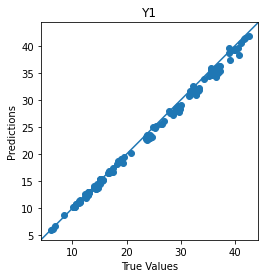

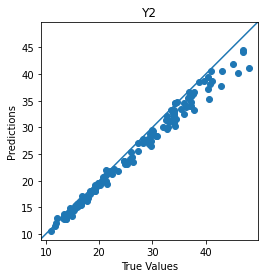

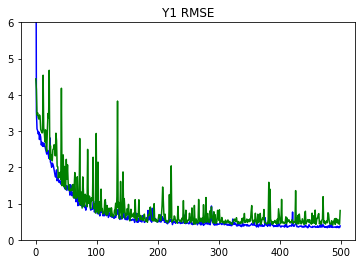

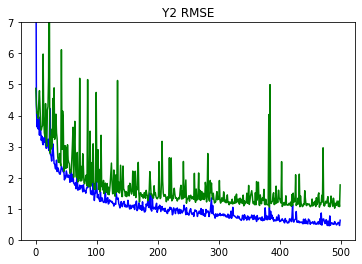

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)